# Tweets about BLM in Minnesota during the summer of 2020

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import re
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
minnesota = pd.read_csv('minnesota_classified.csv')
minnesota.head()

,tweet_id,tweet_created_dt,retweets,favorites,tweet_text,sentiment
0,1245141138492850177,2020-04-01 00:09:15,0,1,watching #blacklightning s3e08 #blacklivesmatt...,anticipation
1,1245142183063289859,2020-04-01 00:13:24,0,3,i agree #blacklivesmatter,trust
2,1245161385392320515,2020-04-01 01:29:42,0,0,i guess racism made them do it. can not we all...,surprise
3,1245202864001167360,2020-04-01 04:14:32,0,0,census 2020 complete! #census2020 #blacklivesm...,trust
4,1245333473709129728,2020-04-01 12:53:31,0,0,there is a video online of a cop. speaking out...,fear


We see that the data contains tweets, as well as the sentiment attached to it according to some user's model. 

In [3]:
minnesota_tweet = minnesota.tweet_text

## Data by Sentiment

In [12]:
sent = minnesota.groupby('sentiment').tweet_text.count()
sent

sentiment
anger             2709
anticipation     53089
disgust           6995
fear             55976
joy              12726
sadness           1645
surprise         11721
trust           164209
Name: tweet_text, dtype: int64

In [13]:
sentiment_count = {
    'sentiments': ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise'],
    'tweets': [2709,53089,6995,55976,12726,1645,11721],
    'color': ['darkslategray', 'lightcoral', 'turquoise', 'sienna', 'orange', 'thistle', 'royalblue']
}

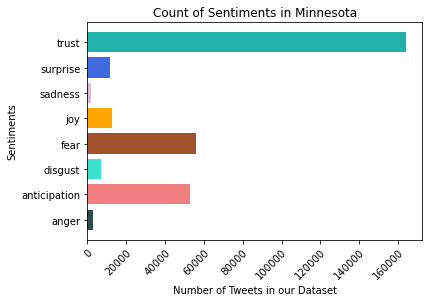

In [42]:
colors = ['darkslategray', 'lightcoral', 'turquoise', 'sienna', 'orange', 'thistle', 'royalblue', 'lightseagreen']
plt.barh(sent.index, sent.values, color = colors)
plt.ylabel('Sentiments')
plt.xlabel('Number of Tweets in our Dataset')
plt.xticks(rotation = 45, ha = 'right', rotation_mode = 'anchor')
plt.title('Count of Sentiments in Minnesota')
plt.show()

For diversity of plots, I will recreate this graphic using a bubble chart. For clarity, I will remove the 'trust' sentiment, since around half of the tweets in this dataset have been classified as trust.

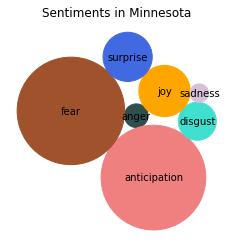

In [15]:
class BubbleChart:
    def __init__(self, area, bubble_spacing=0):
        area = np.asarray(area)
        r = np.sqrt(area / np.pi)

        self.bubble_spacing = bubble_spacing
        self.bubbles = np.ones((len(area), 4))
        self.bubbles[:, 2] = r
        self.bubbles[:, 3] = area
        self.maxstep = 2 * self.bubbles[:, 2].max() + self.bubble_spacing
        self.step_dist = self.maxstep / 2

        # calculate initial grid layout for bubbles
        length = np.ceil(np.sqrt(len(self.bubbles)))
        grid = np.arange(length) * self.maxstep
        gx, gy = np.meshgrid(grid, grid)
        self.bubbles[:, 0] = gx.flatten()[:len(self.bubbles)]
        self.bubbles[:, 1] = gy.flatten()[:len(self.bubbles)]

        self.com = self.center_of_mass()

    def center_of_mass(self):
        return np.average(
            self.bubbles[:, :2], axis=0, weights=self.bubbles[:, 3]
        )

    def center_distance(self, bubble, bubbles):
        return np.hypot(bubble[0] - bubbles[:, 0],
                        bubble[1] - bubbles[:, 1])

    def outline_distance(self, bubble, bubbles):
        center_distance = self.center_distance(bubble, bubbles)
        return center_distance - bubble[2] - \
            bubbles[:, 2] - self.bubble_spacing

    def check_collisions(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return len(distance[distance < 0])

    def collides_with(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        idx_min = np.argmin(distance)
        return idx_min if type(idx_min) == np.ndarray else [idx_min]

    def collapse(self, n_iterations=50):
        for _i in range(n_iterations):
            moves = 0
            for i in range(len(self.bubbles)):
                rest_bub = np.delete(self.bubbles, i, 0)
                # try to move directly towards the center of mass
                # direction vector from bubble to the center of mass
                dir_vec = self.com - self.bubbles[i, :2]

                # shorten direction vector to have length of 1
                dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))

                # calculate new bubble position
                new_point = self.bubbles[i, :2] + dir_vec * self.step_dist
                new_bubble = np.append(new_point, self.bubbles[i, 2:4])

                # check whether new bubble collides with other bubbles
                if not self.check_collisions(new_bubble, rest_bub):
                    self.bubbles[i, :] = new_bubble
                    self.com = self.center_of_mass()
                    moves += 1
                else:
                    # try to move around a bubble that you collide with
                    # find colliding bubble
                    for colliding in self.collides_with(new_bubble, rest_bub):
                        # calculate direction vector
                        dir_vec = rest_bub[colliding, :2] - self.bubbles[i, :2]
                        dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
                        # calculate orthogonal vector
                        orth = np.array([dir_vec[1], -dir_vec[0]])
                        # test which direction to go
                        new_point1 = (self.bubbles[i, :2] + orth *
                                      self.step_dist)
                        new_point2 = (self.bubbles[i, :2] - orth *
                                      self.step_dist)
                        dist1 = self.center_distance(
                            self.com, np.array([new_point1]))
                        dist2 = self.center_distance(
                            self.com, np.array([new_point2]))
                        new_point = new_point1 if dist1 < dist2 else new_point2
                        new_bubble = np.append(new_point, self.bubbles[i, 2:4])
                        if not self.check_collisions(new_bubble, rest_bub):
                            self.bubbles[i, :] = new_bubble
                            self.com = self.center_of_mass()

            if moves / len(self.bubbles) < 0.1:
                self.step_dist = self.step_dist / 2

    def plot(self, ax, labels, colors):
        for i in range(len(self.bubbles)):
            circ = plt.Circle(
                self.bubbles[i, :2], self.bubbles[i, 2], color=colors[i])
            ax.add_patch(circ)
            ax.text(*self.bubbles[i, :2], labels[i],
                    horizontalalignment='center', verticalalignment='center')


bubble_chart = BubbleChart(area=sentiment_count['tweets'],
                           bubble_spacing=0.1)

bubble_chart.collapse()

fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
bubble_chart.plot(
    ax, sentiment_count['sentiments'], sentiment_count['color'])
ax.axis("off")
ax.relim()
ax.autoscale_view()
ax.set_title('Sentiments in Minnesota')

plt.show()

### Sorting by Hashtag

In [16]:
hashtag_dict = {}
hashtag_list = []
for tweet in minnesota_tweet:
    words = tweet.split()
    for word in words:
        if word[0] == '#':
            hashtag_list.append(word)
            if word in hashtag_dict:
                hashtag_dict[word] += 1
            else:
                hashtag_dict[word] = 0

In [17]:
sorted(hashtag_dict, key = hashtag_dict.get, reverse = True)[:5]

['#blacklivesmatter',
 '#georgefloyd',
 '#blm',
 '#justiceforgeorgefloyd',
 '#nojusticenopeace']

The above are the five most common hashtags in the dataset.

In [7]:
hashtags = dict(sorted(hashtag_dict.items(), key=lambda item: item[1], reverse = True)[:15])

In [7]:
hashtags

{'#blacklivesmatter': 150530,
 '#georgefloyd': 35895,
 '#blm': 15078,
 '#justiceforgeorgefloyd': 8885,
 '#nojusticenopeace': 5070,
 '#blackouttuesday': 4684,
 '#icantbreathe': 4360,
 '#breonnataylor': 4054,
 '#blacklivesmatters': 3879,
 '#black_lives_matter': 3618,
 '#protests2020': 3201,
 '#protest': 2960,
 '#policebrutality': 2793,
 '#justiceforbreonnataylor': 2441,
 '#georgefloydprotests': 2402}

These are the fifteen most common hashtags in the dataset, along with the number of tweets that use this hashtag.

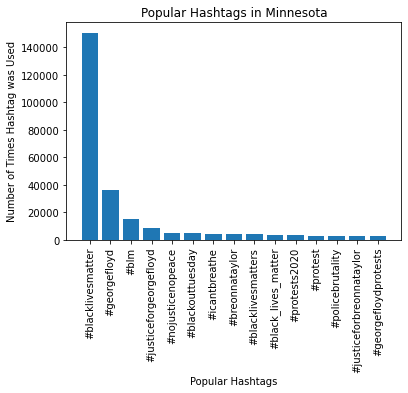

In [8]:
top_hashtags = sorted(hashtag_dict, key = hashtag_dict.get, reverse = True)[:15]
top_3_hashtags = sorted(hashtag_dict, key = hashtag_dict.get, reverse = True)[:3]
hashtag_list_reduced = []
for i in hashtag_list:
    if i in top_hashtags:
        hashtag_list_reduced.append(i)
plt.bar(hashtags.keys(), hashtags.values())
plt.xticks(rotation = 90)
plt.xlabel('Popular Hashtags')
plt.ylabel('Number of Times Hashtag was Used')
plt.title('Popular Hashtags in Minnesota')
plt.show()

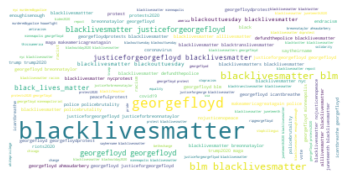

In [10]:
my_string=(" ").join(hashtag_list)
wordcloud = WordCloud(background_color = 'white').generate(my_string)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Generalizing this process through different sentiments

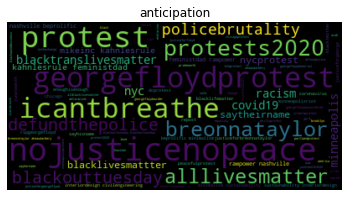

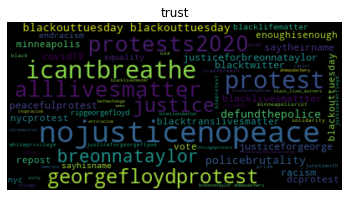

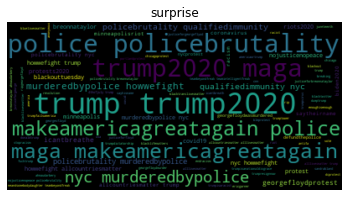

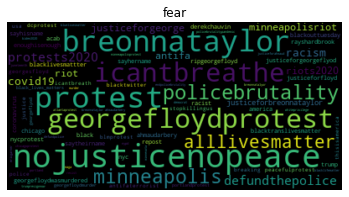

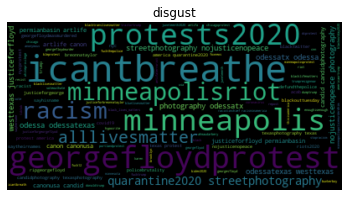

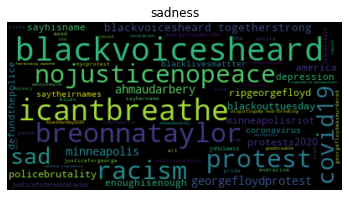

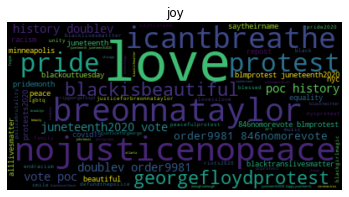

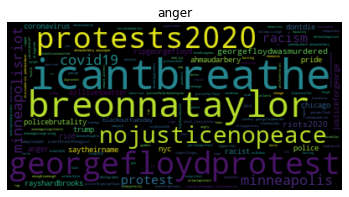

In [13]:
sentiments = minnesota.sentiment.unique()
for sentiment in sentiments:
    dataset = minnesota[minnesota.sentiment == sentiment]
    dataset_tweet = dataset.tweet_text
    hashtag_dict = {}
    sent_hashtag_list = []
    for tweet in dataset_tweet:
        words = tweet.split()
        for word in words:
            if word[0] == '#':
                no_punc = re.sub(r'[^\w\s]', '', word)
                sent_hashtag_list.append(no_punc)
                if word in hashtag_dict:
                    hashtag_dict[word] += 1
                else:
                    hashtag_dict[word] = 0
    reduced_hashtag_list = []
    for i in sent_hashtag_list:
        if i not in ['blacklivesmatter', 'georgefloyd', 'blm', 'justiceforgeorgefloyd', 'black_lives_matter', 'blacklivesmatters']:
            reduced_hashtag_list.append(i)
    my_string=(" ").join(reduced_hashtag_list)
    wordcloud = WordCloud().generate(my_string)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(sentiment)
    plt.axis("off")
    plt.show()

Seeing the most common hashtags per sentiment is interesting, but it may be more insightful to find the most common words in general.

## Cleaning Tweets

In [19]:
import nltk;
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
import string

In [23]:
# Remove punctation and numbers
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

In [24]:
minnesota['tweet_text'] = minnesota['tweet_text'].apply(lambda x: remove_punct(x))

In [25]:
# Tokenize the text
def tokenization(text):
    text = re.split('\W+', text)
    return text

In [26]:
minnesota['tweet_text'] = minnesota['tweet_text'].apply(lambda x: tokenization(x.lower()))

In [27]:
# Remove stop words
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text

In [28]:
minnesota['tweet_text'] = minnesota['tweet_text'].apply(lambda x: remove_stopwords(x))

In [29]:
# Stemming
ps = nltk.PorterStemmer()

def stemming(text):
    text = [ps.stem(word) for word in text]
    return text

In [30]:
# Lemmatizing
lemma = WordNetLemmatizer()
def lemmatizer(text):
    text = [lemma.lemmatize(word) for word in text]
    return text

In [31]:
minnesota['tweet_text'] = minnesota['tweet_text'].apply(lambda x: lemmatizer(x))

Note: In typical NLP problems, we should stem the text. However, in this case, stemming will change too many important words, such as 'blacklivesmatter' or 'funeral'. 

In [32]:
minnesota.head()

,tweet_id,tweet_created_dt,retweets,favorites,tweet_text,sentiment
0,1245141138492850177,2020-04-01 00:09:15,0,1,"[watching, blacklightning, se, blacklivesmatte...",anticipation
1,1245142183063289859,2020-04-01 00:13:24,0,3,"[agree, blacklivesmatter]",trust
2,1245161385392320515,2020-04-01 01:29:42,0,0,"[guess, racism, made, get, along, read, memo, ...",surprise
3,1245202864001167360,2020-04-01 04:14:32,0,0,"[census, complete, census, blacklivesmatter, m...",trust
4,1245333473709129728,2020-04-01 12:53:31,0,0,"[video, online, cop, speaking, black, life, ma...",fear


In [33]:
all_words = []
for i in range(len(minnesota.tweet_text)):
    for j in range(len(minnesota.tweet_text[i])):
        all_words.append(minnesota.tweet_text[i][j])

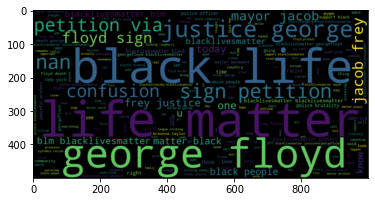

In [34]:
wordcloud_full = WordCloud(width = 1000, height = 500).generate(" ".join(all_words))
plt.imshow(wordcloud_full, interpolation='bilinear')

## Finding Most Common Words Per Sentiment

In [39]:
sentiments = minnesota.sentiment.unique()
for sentiment in sentiments:
    dataset = minnesota[minnesota.sentiment == sentiment]
    dataset_tweet = dataset.tweet_text
    hashtag_dict = {}
    sent_hashtag_list = []
    for tweet in dataset_tweet:
        for word in tweet:
            if word in hashtag_dict:
                hashtag_dict[word] += 1
            else:
                hashtag_dict[word] = 0
    print(sentiment + ': ')
    for i in sorted(hashtag_dict, key = hashtag_dict.get, reverse = True)[:14]:
        if i not in ['black', 'life', 'matter', 'blacklivesmatter', 'floyd', 'george', 'georgefloyd']:
            print(i)
    print('\n')

anticipation: 
protest
time

people
blm
today
de


trust: 
justice
people
protest
police
white
blm



surprise: 
trump
people
protest

de
la
maga


fear: 
police
people
protest
death
murder
cop
killed


disgust: 
shit
people
de
sick
racist
disgusting
say


sadness: 
sad
mourn
see
hear
fight
people
lost


joy: 
happy
love
beautiful
family

people
nan


anger: 
people
outrage
protest
rage
anger

get




There are many interesting findings from this. We see the common words of 'beautiful' and 'love' associated with the happy sentiment, while fear-filled tweets contain the words 'killed' and 'death'. 

## Plotting common words by sentiment

In [40]:
word_dict = {}
tweets = minnesota.tweet_text
for tweet in tweets:
    for word in tweet:
        if word in word_dict:
            word_dict[word] += 1
        else:
            word_dict[word] = 0

In [56]:
# Remove trust sentiment tweets for the following plots
no_trust = minnesota[minnesota.sentiment != 'trust'].reset_index()

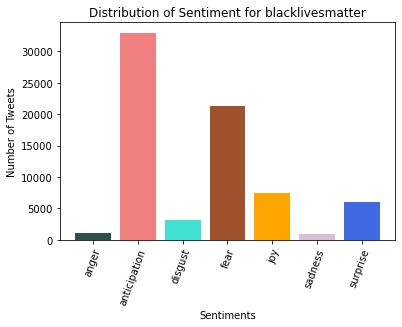

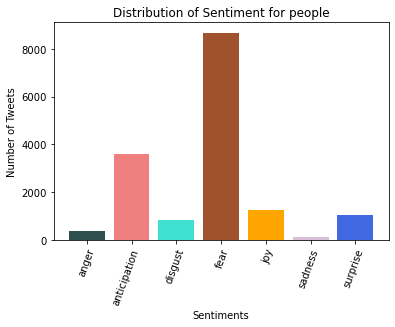

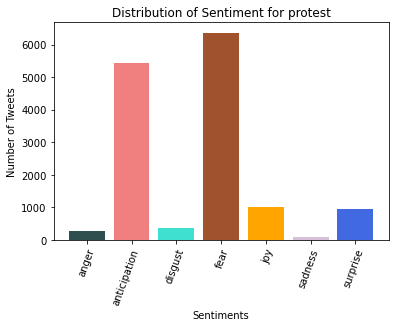

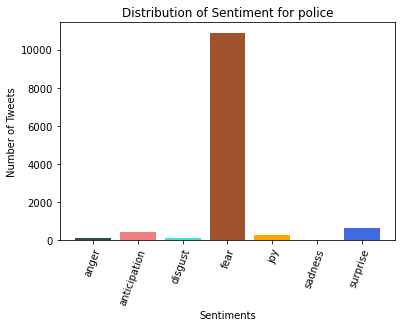

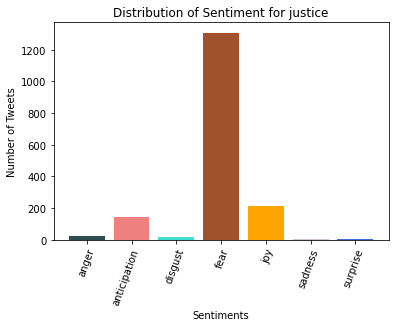

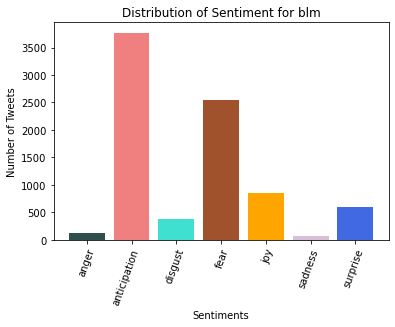

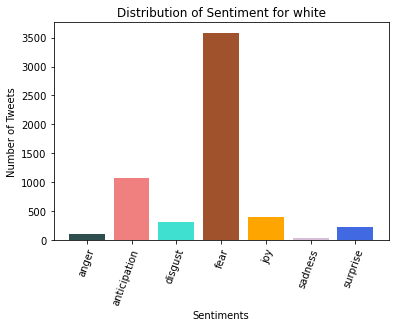

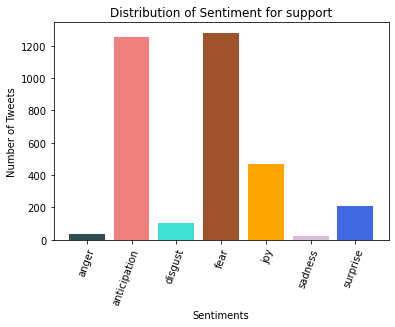

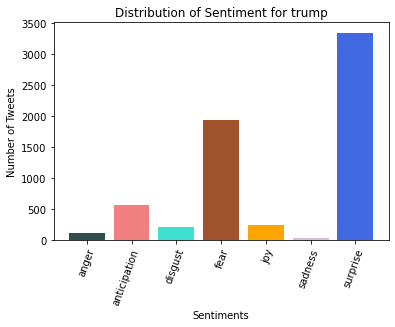

In [60]:
top_words = ['blacklivesmatter', 'people', 'protest', 'police', 'justice', 'blm', 'white', 'support', 'trump']
for word in top_words:
    sentiment_dict = {'anger':0, 'anticipation':0, 'disgust':0, 'fear':0, 'joy':0, 'sadness':0, 'surprise':0}
    for i in range(len(no_trust)):
        sent = no_trust.sentiment[i]
        if word in no_trust.tweet_text[i]:
            sentiment_dict[sent] += 1
    plt.bar(sentiment_dict.keys(), sentiment_dict.values(), color = colors)
    plt.xlabel('Sentiments')
    plt.ylabel('Number of Tweets')
    plt.xticks(rotation = 70, ha = 'right', rotation_mode = 'anchor')
    plt.title('Distribution of Sentiment for ' + word)
    plt.show()